In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from mug_cakes import bo, gp, kernel, utils
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import math

# Mug Cake Experiments

## Pick Hyperparameters

In [3]:
# pick parameters for GP
s2f = 1**2
scale = 0.08**2
# scale = 0.2**2
s2e = 0.3**2
x_true = np.array([s2f, scale, s2e])
J = 3
var_b = 0.2**2

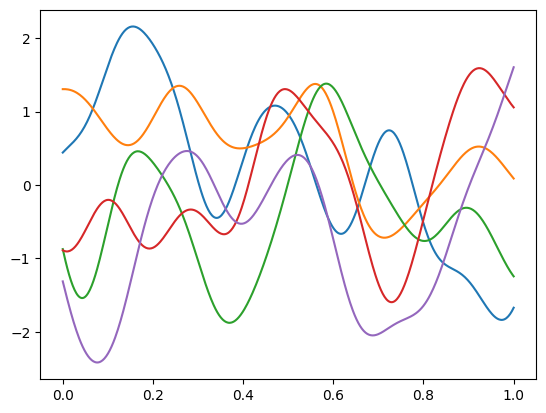

In [4]:
# Take a look and see if the samples are reasonable
N = 500

# sample data
X = np.linspace(0, 1, N).reshape(-1, 1)
# X = np.random.rand(N, 1)
B = np.zeros(N, dtype=np.uint64)
B[: N // 2] = 1
# X[: N // 2] -= 0.5
# X = utils.rowpeat(X, J)
K = kernel.rbf(X, X, scale, s2f)
var = bo.full_cov(K, J, B, 0, 0)
for _ in range(5):
    Y = stats.multivariate_normal.rvs(cov=var)[:N]
    plt.plot(X, Y)
# res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,J,var_b), bounds=bounds)

In [13]:
# sample data and look at posterior
X = np.array([0, 1, 0.5]).reshape(-1, 1)
N = len(X)
B = np.zeros(N, dtype=np.uint64)
B[: N // 2] = 1
# X[: N // 2] -= 0.5
# X = utils.rowpeat(X, J)
K = kernel.rbf(X, X, scale, s2f)
var = bo.full_cov(K, J, B, s2e, var_b)
Y = np.array([-5, -5, 0])

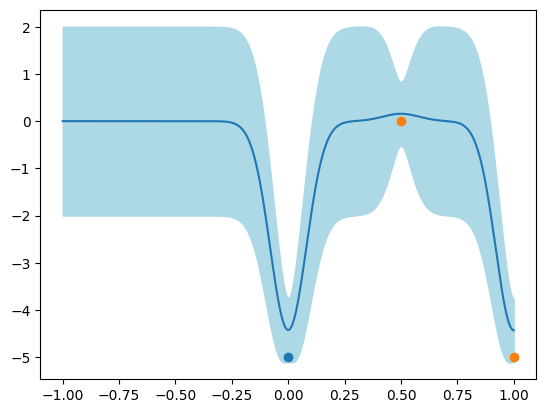

In [15]:
# hparams_mle = bo.optimize_rbf_params(
#     X, Y, J, B, var_b, log_hparam_bounds=log_hparam_bounds
# )
hparams_mle = np.array([s2f, scale, s2e])
N_star = 1000
X_star = np.linspace(-1, 1, N_star).reshape(-1, 1)
K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
var = bo.full_cov(K, J, B, hparams_mle[2], var_b)[:N, :N]
K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
post_mean2 = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
post_var2 = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)

plt.fill_between(
    X_star.reshape(-1),
    post_mean2 - 2 * post_var2**0.5,
    post_mean2 + 2 * post_var2**0.5,
    color="lightblue",
)
plt.plot(X_star, post_mean2)
plt.scatter(X[B == 1], Y[B == 1])
plt.scatter(X[B == 0], Y[B == 0])
# plt.ylim(-5, 5);

## Perform Experiment

In [8]:
# At every iteration, update X and y

N_b = 2
X = np.array(
    [
        [9.99999900e-01, 9.99999999e-15, 2.11072374e-08, 7.88927526e-08],
        [1.000000e-07, 9.999999e-08, 9.999997e-01, 9.999998e-08],
        [1.000000e-07, 9.999999e-08, 9.999998e-08, 9.999997e-01],
        [1.00000000e-07, 9.99999800e-01, 9.99999800e-08, 9.99200722e-15],
        [0.25, 0.25, 0.25, 0.25],
        [0.14642632, 0.25707181, 0.23508935, 0.36141251],
        [0.19270833, 0.19270833, 0.24479167, 0.36979167],
        [0.20418848, 0.17277487, 0.2460733, 0.37696335],
        [0.17801047, 0.19371728, 0.26701571, 0.36125654],
        [0.19473684, 0.2, 0.25263158, 0.35263158],
        # fake
    ]
)
B = np.array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0], dtype=np.uint64)
y = (
    np.array(
        [
            0,
            0,
            0,
            0,
            2,
            3,
            6,
            4,
            5,
            5,
        ]
    )
    - 2
)
state = bo.BoState(X, y, N_b, B, var_b, simplex=True)

In [9]:
# Get the point to evaluate
x_new, (s2f_map, scale2_map, s2e_map), x_M = bo.bo_iter(
    state,
    disp=0,
    hparams=hparams,
)
print(x_new)
m = utils.to_measurements(x_new, 24)

array([0.19687173, 0.20063511, 0.25124899, 0.35124417])

In [11]:
# Print it in a friendly way
ingredients = ["flour", "sugar", "cocoa", "milk"]
print(utils.format_ingredients(m, ingredients))

                    flour               sugar               cocoa               milk                
ones:               4                   4                   6                   8                   
halves:             1                   1                   0                   0                   
quarters:           1                   1                   0                   1                   
eighths:            0                   0                   0                   1                   
16ths:              0                   1                   0                   1                   



In [71]:
# the actually ratios used after rounding
x_actual = (m * np.array([1, 0.5, 0.25, 0.125, 0]).reshape(-1, 1)).sum(axis=0)
x_actual /= x_actual.sum()
x_actual

array([0.18324607, 0.11518325, 0.27748691, 0.42408377])

In [ ]:
# end of bo loop

In [ ]:
# save data to txt file so we can parse it and generate figures.
data = np.hstack((X, y.reshape(-1, 1) + 2, B.reshape(-1, 1)))
np.savetxt("../paper/data/experiments.txt", data)